In [1]:
import dask
import dask.dataframe as dd
import glob
import pandas as pd
from pathlib import Path 

import numpy as np
import scipy.stats as sps
from sklearn import linear_model

from distributed import Client
client = Client()

/home/marek/NGIMS-hp/env/lib/python3.7/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [111]:
PATH_MAVEN = Path("/home/marek")
PATH_NGI = Path(PATH_MAVEN) / "maven" / "data" / "sci" / "ngi"
PATH_NGI_L2 = Path(PATH_NGI) / "l2"

In [215]:
year = 2019

In [216]:
test_dir = Path(PATH_NGI_L2, f"{year}/*/*.csv")

In [217]:
meta_cols = {
    "orbit": int,
    "alt": float,
    "species": str,
    "abundance": float,
    "t_unix": float
}

In [218]:
ddf = dd.read_csv(
    test_dir, 
    assume_missing=True, 
    usecols=["orbit", "alt", "species", "abundance", "t_unix"],
    include_path_column=True,
    dtype=meta_cols,
    na_values = [" ", "-999", np.inf, "Inf", "inf"]
)

In [219]:
#@dask.delayed()
def IO_orb(orbdata,io='I') -> pd.DataFrame:
    minalt = orbdata['alt'].min()
    peri_t = orbdata[orbdata['alt']==minalt]['t_unix'].unique()
    #if len(peri_t)>1:
    #    sys.exit('Non-unique time found at periapse '+str(orbdata['orbit'].unique()))
    #else:
    if io == 'I':
        return orbdata[orbdata['t_unix']<=peri_t[0]]
    elif io =='O':
        return orbdata[orbdata['t_unix']>peri_t[0]]
    else:
        return orbdata

## Make orbit-filename map

For each orbit, get filenames of orbits with +/- x orbits

In [220]:
%%time
orb_path_map = ddf[["orbit", "path"]].drop_duplicates().compute()
del ddf

CPU times: user 21.9 s, sys: 1.12 s, total: 23 s
Wall time: 1min 56s


In [221]:
orb_step = 5
orb_orb_map = {x: list(range(x - orb_step, x + orb_step + 1)) for x in orb_path_map["orbit"]}

In [222]:
%%time
orb_filename_map = {
    x: orb_path_map["path"][orb_path_map["orbit"].isin(orb_orb_map[x])].tolist() for x in orb_orb_map.keys()
}

CPU times: user 776 ms, sys: 4.71 ms, total: 781 ms
Wall time: 754 ms


In [223]:
#@dask.delayed()
def fit_ratio_alt(df):
    x = df[["alt"]]
    y = np.log(df["N2/Ar"])
    lr = linear_model.LinearRegression()
    lr.fit(x, y)
    return lr

#@dask.delayed()
def hp_from_fit(ratio, slope, intercept):
    return (np.log(ratio)-intercept)/slope

In [224]:
@dask.delayed()
def hp_files(files):
    temp_ddf = dd.read_csv(
        files, 
        assume_missing=True, 
        usecols=["orbit", "alt", "species", "abundance", "t_unix"],
        dtype=meta_cols,
        na_values = [" ", "-999", np.inf, "Inf", "inf"]
    )
    temp_ddf = temp_ddf.map_partitions(IO_orb, meta=temp_ddf)
    temp_ddf = temp_ddf[(temp_ddf["abundance"] > 0.) & (temp_ddf["alt"] < 250) & (temp_ddf["species"].isin(["Ar", "N2"]))]
    df = temp_ddf.compute()
    #temp_ddf = temp_ddf.set_index('orbit', sorted=True, drop=False)
    #temp_ddf.reset_index(drop=True)
    norbs = len(df["orbit"].unique())
    df = df.pivot_table(values=["abundance"], index=["orbit","alt", "species"]).unstack()
    df["N2/Ar"] = df["abundance"]["N2"] / df["abundance"]["Ar"]
    df = df["N2/Ar"].reset_index().dropna(subset=["alt", "N2/Ar"])
    try:
        fit = fit_ratio_alt(df)
    except ValueError:
        return {"hp_alt": np.nan, "fit_slope": np.nan, "fit_intercept": np.nan, "n_orbits": norbs}
    hp = hp_from_fit(1.25, fit.coef_[0], fit.intercept_)
    hp_res = {"hp_alt": hp, "fit_slope": fit.coef_[0], "fit_intercept": fit.intercept_, "n_orbits": norbs}
    return hp_res

In [225]:
%%time
results_hp = []
results_orb = []
for orb, files in orb_filename_map.items():
    results_orb.append(orb)
    res_single = hp_files(files)
    results_hp.append(res_single)

CPU times: user 88.8 ms, sys: 4.3 ms, total: 93.1 ms
Wall time: 86.7 ms


In [226]:
%%time
results = dask.compute(*results_hp)

CPU times: user 1min 46s, sys: 7.1 s, total: 1min 53s
Wall time: 15min 43s


In [227]:
%%time
res_df = pd.DataFrame(results)
res_df["orbit"] = results_orb

CPU times: user 5.44 ms, sys: 99 µs, total: 5.54 ms
Wall time: 5.06 ms


In [228]:
res_df.set_index("orbit")

,hp_alt,fit_slope,fit_intercept,n_orbits
orbit,,,,
8306,102.628482,0.034582,-3.325963,4
8307,106.224089,0.037310,-3.740060,5
8308,106.613691,0.037671,-3.793144,6
8311,107.644581,0.038315,-3.901257,9
8312,102.628505,0.035211,-3.390477,9
...,...,...,...,...
10629,95.870800,0.022710,-1.954083,10
10630,95.586664,0.022672,-1.943978,9
10631,93.280291,0.022258,-1.853080,8


In [229]:
21 * 5 / 60

1.75

In [230]:
import matplotlib.pyplot as plt

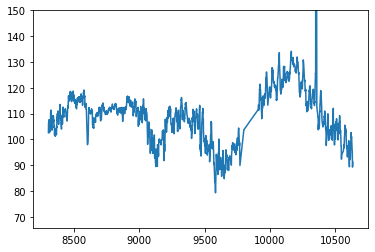

In [236]:
plt.figure()
plt.plot(res_df["orbit"], res_df["hp_alt"])
plt.ylim(ymax=150)
plt.show()

In [232]:
res_df.to_csv(f"../output/{year}_hp.csv", index=False)

In [237]:
res_df[res_df["hp_alt"].isnull()]

,hp_alt,fit_slope,fit_intercept,n_orbits,orbit


In [190]:
res_df[res_df["orbit"] > 10000]

,hp_alt,fit_slope,fit_intercept,n_orbits,orbit
1390,111.021294,0.027549,-2.835332,1,29514


In [214]:
print(orb_path_map[orb_path_map["orbit"] == 29514]["path"].item())

/home/marek/maven/data/sci/ngi/l2/2018/11/mvn_ngi_l2_csn-abund-29514_20181107T071715_v08_r01.csv


In [239]:
pieces = []
for data in [f"../output/{x}_hp.csv" for x in [2015, 2016, 2017, 2018, 2019]]:
    pieces.append(pd.read_csv(data))
hp_data = pd.concat(pieces)

In [247]:
hp_data = hp_data[hp_data["n_orbits"] == 11]

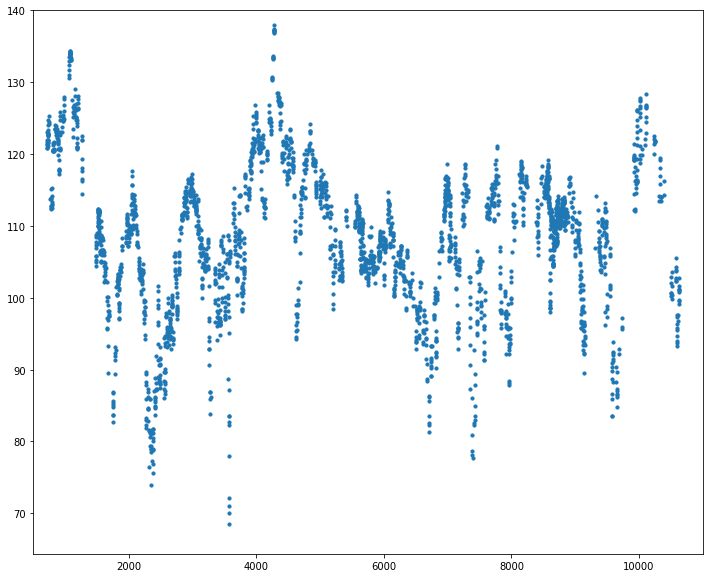

In [263]:
plt.figure(figsize=(12, 10))
plt.scatter(hp_data["orbit"], hp_data["hp_alt"], s=10)
plt.ylim(ymax=140)
plt.xlim(500,11000)
plt.show()

In [250]:
hp_data[hp_data["hp_alt"] > 140]

,hp_alt,fit_slope,fit_intercept,n_orbits,orbit
590,147.665317,0.020202,-2.760057,11,1664
591,146.297245,0.018843,-2.533565,11,1665
592,148.773420,0.022122,-3.068029,11,1666
593,149.653864,0.022922,-3.207250,11,1667
594,150.514882,0.023540,-3.320017,11,1668
595,149.727412,0.021896,-3.055308,11,1669
596,151.993601,0.024092,-3.438681,11,1670
597,151.370230,0.022181,-3.134400,11,1671
598,151.959191,0.021463,-3.038427,11,1672
599,152.191269,0.022884,-3.259532,11,1673
